In [1]:
#!pip install --upgrade pip
#!pip install -U numpy
#!pip install gensim 
#!pip install spacy==2.0.10
#!pip install greenlet
#!pip install allennlp --user
#!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html

### Cuda Nightly
"cuda_8": "https://download.pytorch.org/whl/nightly/cu80/torch_nightly.html",  
"cuda_9": "https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html",  
"cuda_10": "https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html",  
"no_cuda": "https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html",  

In [2]:
# Torch, Sklearn imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
## AllenNLP
import allennlp
from allennlp.modules.elmo import Elmo, batch_to_ids
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from allennlp.modules.token_embedders import BertEmbedder

print("PyTorch: {}".format(torch.__version__))
print("AllenNLP: {}".format(allennlp.__version__))
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print("Using CUDA device: {}".format(device))
    print("- # GPU device: {}".format(torch.cuda.device_count()))
    print("- Device Name: {}".format(torch.cuda.get_device_name(device)))
    print("- Device Proprierties: {}".format(torch.cuda.get_device_properties(device)))

PyTorch: 1.0.0.dev20190206
AllenNLP: 0.8.1
Using CUDA device: 0
- # GPU device: 1
- Device Name: GeForce GTX 1080 Ti
- Device Proprierties: _CudaDeviceProperties(name='GeForce GTX 1080 Ti', major=6, minor=1, total_memory=11175MB, multi_processor_count=28)


In [4]:
## NLP libs
from nltk import download
import gensim
from nltk.corpus import stopwords
download('stopwords')

## Sklearn imports
from sklearn.datasets import fetch_20newsgroups

## General libs
import numpy as np
import pandas as pd
from string import punctuation
import os, re, sys, json, requests, pickle

02/07/2019 22:37:25 - INFO - gensim.summarization.textcleaner -   'pattern' package not found; tag filters are not available for English
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/roberto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def transformText(text, do_stop=False, do_stem=False, do_lema = False):
    stops = set(stopwords.words("english"))
    # Convert text to lower
    text = text.lower()
    
    # Removing E-mails  
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    text = re.sub(r'\S*@\S*\s?', r' ', text)
    
    # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    
    # Removing Newline
    text = text.rstrip()
    # Removing all the stopwords
    if (do_stop==True):
        filtered_words = [word for word in text.split() if word not in stops]
    else:
        filtered_words = [word for word in text.split()]
    
    # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
    
    # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
    
    # Stemming
    if (do_stem==True):
        text = gensim.parsing.preprocessing.stem_text(text)
    
    # Lemmatization
    if (do_lema==True):
        text = do_lemmatization(text)   
        
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    return text

In [6]:
## Lemmatization function based on Spacy Library
def lemmatizer_spacy(text):        
    sent = []
    doc = spacy_en(text)
    for word in doc:
        if word.lemma_ == "-PRON-":
            sent.append(word.text)
        else:
            sent.append(word.lemma_)
    return " ".join(sent)

def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

### Reading SST1 Datasate

In [7]:
sst1_dataset = pd.read_pickle('dataset/SST1_capado.pkl')

In [9]:
## Number of sentences per label
for i in list(set(sst1_dataset.label)):
    print("LABEL {} - PHRASES {}".format(i,len(sst1_dataset[sst1_dataset.label==i])))

LABEL 0 - PHRASES 5649
LABEL 3 - PHRASES 18158
LABEL 4 - PHRASES 6622
LABEL 1 - PHRASES 17141
LABEL 2 - PHRASES 24550


In [11]:
train_dataset = sst1_dataset[sst1_dataset.split == 'train'].reset_index(drop=True)
test_dataset = sst1_dataset[sst1_dataset.split == 'test'].reset_index(drop=True)
train_dataset['label'] = train_dataset['label'].apply(lambda x: int(x))
test_dataset['label'] = test_dataset['label'].apply(lambda x: int(x))

In [19]:
## Pruning dataset to have few instances per class for augmentation evaluation
pruned_num_phrases = 100
train_pruned = pd.DataFrame(columns = ['sentence', 'label','split'])
valid_pruned = pd.DataFrame(columns = ['sentence', 'label','split'])

In [20]:
for i in list(set(train_dataset.label)):
    print("LABEL {} ---------------------".format(i))
    train_ = train_dataset[train_dataset.label==i][0:pruned_num_phrases]
    valid_ = train_dataset[train_dataset.label==i][pruned_num_phrases:]
    print("# train {}, # valid {}".format(len(train_), len(valid_)))
    train_pruned = pd.concat([train_pruned,train_]).reset_index(drop=True)
    valid_pruned = pd.concat([valid_pruned,valid_]).reset_index(drop=True)

LABEL 0 ---------------------
# train 100, # valid 5140
LABEL 1 ---------------------
# train 100, # valid 16148
LABEL 2 ---------------------
# train 100, # valid 23873
LABEL 3 ---------------------
# train 100, # valid 17283
LABEL 4 ---------------------
# train 100, # valid 5972


In [22]:
train_pruned.tail()

,sentence,label,split
495,"a terrific b movie in fact , the best in recen...",4,train
496,walked away from this new version of e.t. just...,4,train
497,i walked away from this new version of e.t. ju...,4,train
498,'s like dying and going to celluloid heaven,4,train
499,is so rich with period minutiae it 's like dyi...,4,train


In [23]:
valid_pruned.tail()

,sentence,label,split
68411,red dragon '' never cuts corners .,4,train
68412,that makes the formula fresh again,4,train
68413,an enthusiastic charm in fire that makes the f...,4,train
68414,there 's an enthusiastic charm in fire that ma...,4,train
68415,we 've seen the hippie turned yuppie plot befo...,4,train


In [27]:
## Clean Dataset (only stopword removal, punct, ascii - no lemma, stemm)
train_pruned['clean_text']=train_pruned['sentence'].apply(lambda x: transformText(x))
valid_pruned['clean_text']=valid_pruned['sentence'].apply(lambda x: transformText(x))
test_dataset['clean_text']=valid_pruned['sentence'].apply(lambda x: transformText(x))

In [28]:
train_pruned.sentence[0]

"'s not life affirming its vulgar and mean"

In [29]:
train_pruned.clean_text[0]

' s not life affirming its vulgar and mean'

In [30]:
valid_pruned.sentence[200]

"'s a great deal of corny dialogue and preposterous moments"

In [32]:
valid_pruned.clean_text[200]

' s a great deal of corny dialogue and preposterous moments'

In [33]:
## ELMo
elmo_weights_key_path = '../vectors/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5'
elmo_config_key_path = '../vectors/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json'

## S3 Configs for SageMaker
#bucket = 'adp-e-ml-notebooks-sagemaker'             
#prefix = 'vectors'   
#elmo_weights_key = '{}/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5'.format(prefix)
#elmo_weights_key_path = os.path.join('s3://', bucket, elmo_weights_key)
#elmo_config_key = '{}/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json'.format(prefix)
#elmo_config_key_path = os.path.join('s3://', bucket, elmo_config_key)

### Elmo Instance
elmo = Elmo(elmo_config_key_path, 
            elmo_weights_key_path, 
            num_output_representations = 1, 
            dropout=0.3,
            requires_grad = False)
if torch.cuda.is_available():
    elmo = elmo.cuda()

02/07/2019 22:50:17 - INFO - allennlp.modules.elmo -   Initializing ELMo


In [35]:
def get_elmo(sent):
    elmo.eval()
    sent = [sent.split()]
    character_ids = batch_to_ids(sent)
    if torch.cuda.is_available():
        character_ids = character_ids.cuda()
    embeddings = elmo(character_ids)
    rep = embeddings['elmo_representations'][0]
    rep = rep.squeeze(dim=0)
    avg = rep.mean(dim=0)
    avg = avg/torch.norm(avg)
    return avg

In [36]:
get_elmo("what is love baby don't hurt me").mean()

tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)

In [37]:
get_elmo("what is").mean()

tensor(-0.0002, device='cuda:0', grad_fn=<MeanBackward0>)

In [42]:
class Intents(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        
    def __getitem__(self, index):
        phrase = self.data.clean_text[index]
        X = get_elmo(phrase)
        y = self.data.label[index]
        return X, y
    
    def __len__(self):
        return self.len

In [43]:
training_set = Intents(train_pruned)
validing_set = Intents(valid_pruned)

In [47]:
training_set.__len__(), validing_set.__len__()

(500, 68416)

In [48]:
training_set.__getitem__(1)

(tensor([-0.0780, -0.0428, -0.0097,  ..., -0.0022, -0.0037,  0.0341],
        device='cuda:0', grad_fn=<DivBackward0>), 0)

In [49]:
validing_set.__getitem__(400)

(tensor([-0.0236, -0.0163,  0.0315,  ...,  0.0220,  0.0418, -0.0485],
        device='cuda:0', grad_fn=<DivBackward0>), 0)

## Simple MLP Classifier

In [50]:
class SimpleMLP(nn.Module):
    def __init__(self, inputdim, 
                        nclasses, 
                        nhidden, 
                        dropout = 0):
        super(SimpleMLP, self).__init__()
        """
        PARAMETERS:
        -dropout:    dropout for MLP
        """
        
        self.inputdim = inputdim
        self.hidden_dim = nhidden
        self.dropout = dropout
        self.nclasses = nclasses
        self.model = nn.Sequential(
            nn.Linear(self.inputdim, nhidden),
            nn.Dropout(p=self.dropout),
            nn.ReLU(),
            nn.Linear(nhidden, self.nclasses),
            )
        if torch.cuda.is_available():
            self.model = self.model.cuda()
    def forward(self, x):
        log_probs = self.model(x)
        return log_probs

In [53]:
INP_DIM = elmo.get_output_dim()
NUM_LABELS = len(list(set(training_set.data.label)))
NHIDDEN = 256
DROPOUT = 0

In [54]:
model = SimpleMLP(inputdim = INP_DIM ,
              nhidden = NHIDDEN,
              nclasses = NUM_LABELS,
              dropout = DROPOUT)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model = model.to(device)
    model.cuda()

## Training

In [55]:
# Dataloaders Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 0}
max_epochs = 30

train_loader = DataLoader(training_set, **params)
valid_loader = DataLoader(validing_set, **params)
# Hyperparams
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001 
optimizer = optim.Adam(params =  model.parameters(), lr=learning_rate)

In [56]:
for epoch in range(max_epochs):
    print("EPOCH -- {}".format(epoch))
    for i, (sent, label) in enumerate(train_loader):
        optimizer.zero_grad() 
        if torch.cuda.is_available():
            sent = sent.cuda()
            label = label.cuda()
        output = model.forward(sent)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        if i%100 == 0:      
            correct = 0
            total = 0
            for sent, label in valid_loader:      
                if torch.cuda.is_available():
                    sent = sent.cuda()
                    label = label.cuda()
                output = model.forward(sent)
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted.cpu() == label.cpu()).sum()
            accuracy = 100.00 * correct.numpy() / total
            print('LOSS: {}. VALID ACCURACY: {}%'.format(loss.data, accuracy))

EPOCH -- 0


KeyboardInterrupt: 

In [130]:
def get_reply(phrase, model):
    x = get_elmo(phrase)
    logits_out = model.forward(x)
    softmax_out = F.softmax(logits_out, dim=0).cpu()
    _, pred_label = torch.max(softmax_out.data, 0)
    return int(pred_label.cpu().numpy())

In [131]:
get_reply("demote worker", model)

2

In [132]:
get_reply("change my email", model)

3

## Checking test error

In [137]:
correct = 0
total = 0
errors = []
for i in range(len(test_dataset)):
    msg = str(test_dataset['clean_text'][i])
    lbl = test_dataset['label'][i]
    prediction = get_reply(msg, model)
    #print(prediction)
    total +=1
    if prediction == lbl:
        correct += 1
    else:
        errors.append((msg ,lbl))
test_accuracy = 100.00 * correct / total
print("TEST ACCURACY  -- {}".format(test_accuracy))

TEST ACCURACY  -- 22.19626168224299


## Implementing Augmentation Class

In [57]:
%matplotlib inline
from torch.nn.functional import interpolate
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [63]:
train_pruned.tail()

,sentence,label,split,clean_text
495,"a terrific b movie in fact , the best in recen...",4,train,a terrific b movie in fact the best in recent ...
496,walked away from this new version of e.t. just...,4,train,walked away from this new version of e t just ...
497,i walked away from this new version of e.t. ju...,4,train,i walked away from this new version of e t jus...
498,'s like dying and going to celluloid heaven,4,train,s like dying and going to celluloid heaven
499,is so rich with period minutiae it 's like dyi...,4,train,is so rich with period minutiae it s like dyin...


In [64]:
def get_linear_interpolation(label, num_interp_samples, return_all_points=False):
    sentences= list(train_pruned.clean_text[train_dataset.label == label])
    points = np.zeros((elmo.get_output_dim(),len(sentences)))    
    
    for i,utt in enumerate(sentences):
        points[:,i] = get_elmo(utt).detach().cpu().clone().numpy()
    point = torch.tensor(points)
    x = point.unsqueeze(dim=0) 
    
    ## Random selector for which interpolated phrase to pick
    rand_phrase = np.random.randint(num_interp_samples, size = 1)
    
    ## Interpolate phrases
    interp = interpolate(x, size=(num_interp_samples), mode='linear', align_corners=True).squeeze(0).numpy().T
    
    if return_all_points == False:
        interp =interp[rand_phrase].squeeze(0)      ## Pick Randomly 1 point sample
    return interp

In [65]:
get_linear_interpolation(1 , num_interp_samples = 20).shape

(1024,)

In [66]:
get_linear_interpolation(2, num_interp_samples = 20, return_all_points=True).shape

(20, 1024)

In [69]:
def plot_manifold(intents, num_interp_samples, perplexity = 3):
    
    list_intents = {}
    for name in intents:
        phrases = list(train_pruned.clean_text[train_pruned.label == name])
        list_intents.update({name:phrases})
    
    ## List all sentences
    sentences = [item for sublist in list(list_intents.values()) for item in sublist]
    embeddings_np = np.zeros((len(sentences), elmo.get_output_dim()))
    for i,sent in enumerate(sentences):
        embeddings_np[i]= get_elmo(sent).detach().cpu().numpy()
    initial_sent_size = len(sentences)
    
    ## Get syntetic phrases
    for name in list_intents:
        interp = get_linear_interpolation(name, num_interp_samples, return_all_points=True)
        embeddings_np = np.vstack((embeddings_np,interp))
        syntetic_label = "--- interp_{} ---".format(name)
        ## initial sizes
        for i in range(num_interp_samples):
            sentences.append(syntetic_label)

    ## Do TSNE and plot
    tsne=TSNE(n_components=2,perplexity = perplexity, method ='exact',verbose=1)
    sentences_tsne = tsne.fit_transform(embeddings_np)
    plt.subplots(figsize=(30, 15))
    plt.grid()
    
    ## Grouping points by indexes
    points = (sentences_tsne[:initial_sent_size,0], sentences_tsne[:initial_sent_size,1])
    syntetic_points = (sentences_tsne[initial_sent_size:,0], sentences_tsne[initial_sent_size:,1])
    
    ## Ploting points
    plt.scatter(points[0], points[1], c='r', marker='o')
    plt.scatter(syntetic_points[0], syntetic_points[1], c='b', marker='x')

    ## Adding labels
    for label, x, y in zip(sentences[0:initial_sent_size], points[0], points[1]):
        font = {'size' : 10, 'weight' : 'normal'}
        plt.rc('font', **font)
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

    for label, x, y in zip(sentences[initial_sent_size:], syntetic_points[0], syntetic_points[1]):
        font = {'size' : 18, 'weight' : 'bold'}
        plt.rc('font', **font)
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')



[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 0.209122
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.471558
[t-SNE] KL divergence after 1000 iterations: 0.138508


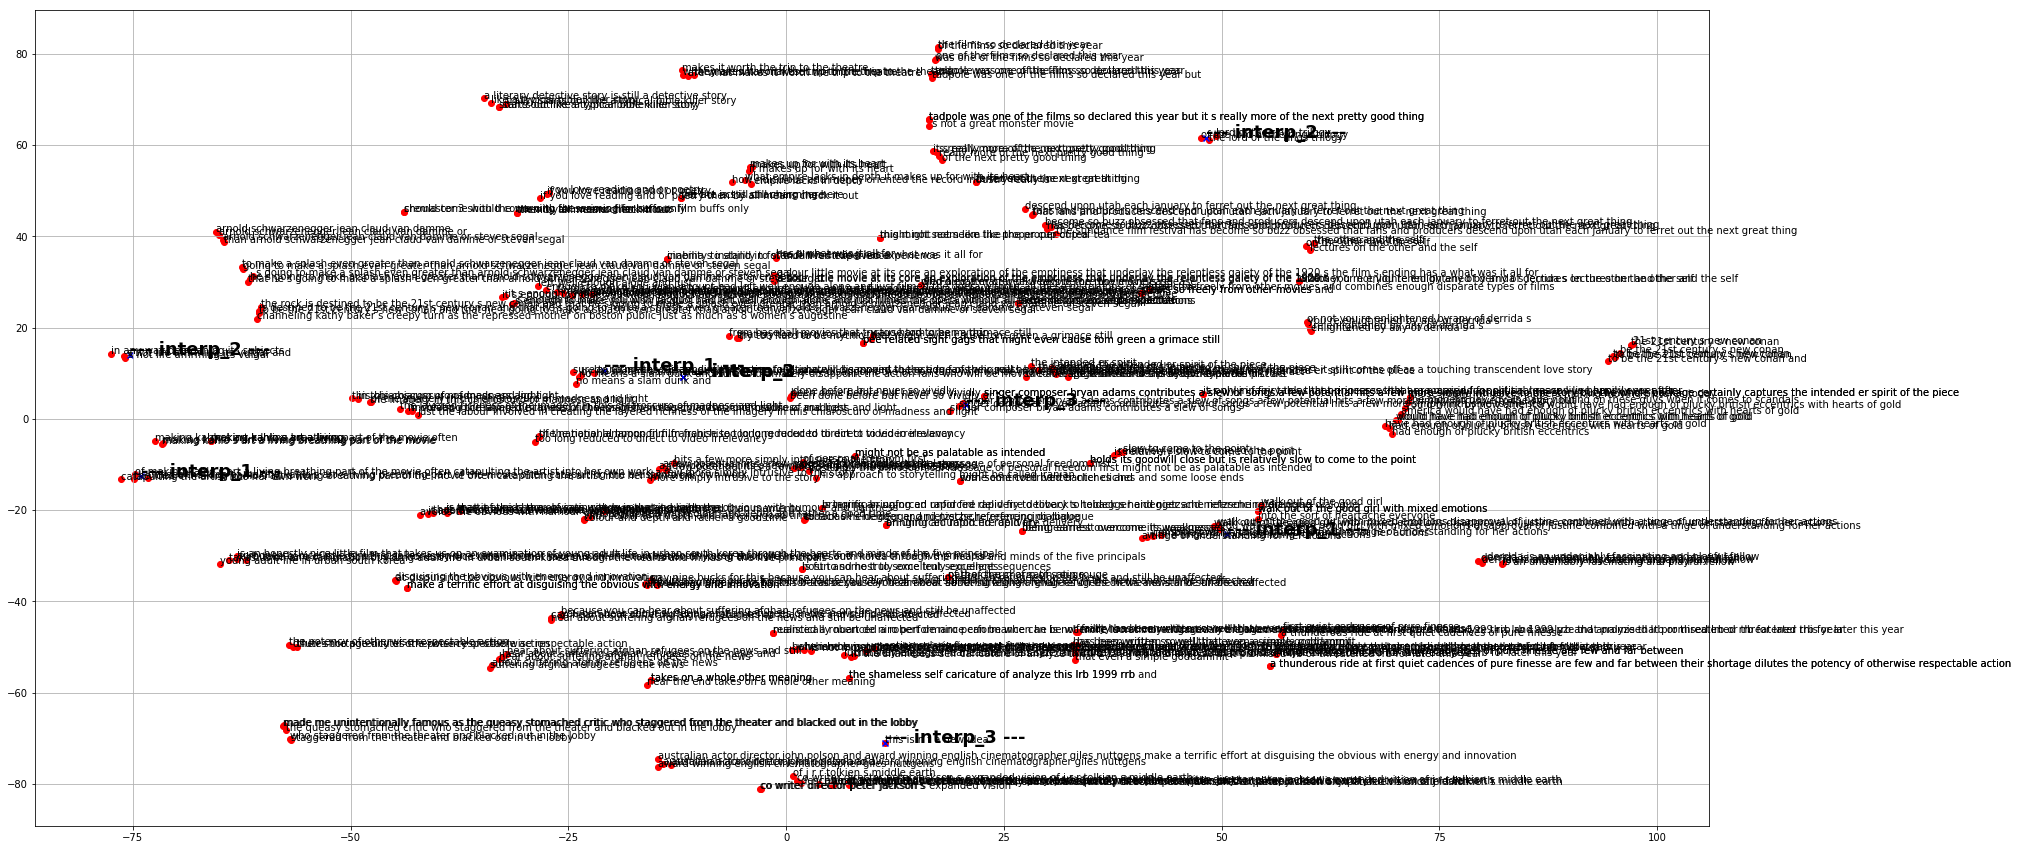

In [70]:
plot_manifold([1,2,3], 3, perplexity = 3)

In [107]:
class AugmentedIntents(Dataset):
    def __init__(self, dataframe, alpha, num_samples = 20, augmentation = True):
        self.len = len(dataframe)
        self.data = dataframe
        self.augmentation = augmentation
        self.num_samples = num_samples
        self.alpha = alpha                          ## probabilty to get a real phrase vs interpolated phrase
        
    def __getitem__(self, index):
        phrase = self.data.clean_text[index]
        y = self.data.label[index]
        if self.augmentation:
            proba = np.random.binomial(1, self.alpha )
            if proba == 1:
                #print("frase normal")
                X = get_elmo(phrase)
            elif proba == 0:
                #print("frase interpolada")
                X = torch.tensor(get_linear_interpolation(y, num_interp_samples = self.num_samples), dtype=torch.float32)
                if torch.cuda.is_available():
                    X = X.cuda()
        else:
            X = get_elmo(phrase)
        return X, y
    
    def __len__(self):
        return self.len

In [108]:
alpha = 0.9
num_samples = 5
training_set = AugmentedIntents(train_pruned, alpha, num_samples, augmentation = True)
validing_set = AugmentedIntents(valid_pruned,  alpha, num_samples, augmentation = False)

In [109]:
n = training_set.__getitem__(1)

In [110]:
n[0].shape

torch.Size([1024])

In [111]:
model_2 = SimpleMLP(inputdim = INP_DIM ,
              nhidden = NHIDDEN,
              nclasses = NUM_LABELS,
              dropout = DROPOUT)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model_2 = model_2.to(device)
    model_2.cuda()

In [112]:
train_loader = DataLoader(training_set, **params)
valid_loader = DataLoader(validing_set, **params)
# Hyperparams
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001 
optimizer = optim.Adam(params =  model_2.parameters(), lr=learning_rate)

In [113]:
for epoch in range(max_epochs):
    print("EPOCH -- {}".format(epoch))
    for i, (sent, label) in enumerate(train_loader):        
        optimizer.zero_grad()
        if torch.cuda.is_available():
            sent = sent.cuda()
            label = label.cuda()
        output = model_2.forward(sent)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            correct = 0
            total = 0
            for sent, label in valid_loader:
                if torch.cuda.is_available():
                    sent = sent.cuda()
                    label = label.cuda()
                output = model_2.forward(sent)
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted.cpu() == label.cpu()).sum()
            accuracy = 100.00 * correct.numpy() / total
            print('LOSS: {}. VALID ACCURACY: {}%'.format(loss.data, accuracy))

EPOCH -- 0


KeyboardInterrupt: 

In [115]:
test_dataset

,sentence,label,split,clean_text
0,"no movement , no yuks , not much of anything .",1,test,collateral damage is trash but it earns extra ...
1,"a gob of drivel so sickly sweet , even the eag...",0,test,feels so distant you might as well be watching...
2,` how many more voyages can this limping but d...,2,test,k 19 will not go down in the annals of cinema ...
3,so relentlessly wholesome it made me want to s...,2,test,nothing original in the way of slapstick seque...
4,"gangs of new york is an unapologetic mess , wh...",0,test,to foul up a screen adaptation of oscar wilde ...
5,"we never really feel involved with the story ,...",0,test,would take a complete moron to foul up a scree...
6,this is one of polanski 's best films .,4,test,it would take a complete moron to foul up a sc...
7,take care of my cat offers a refreshingly diff...,3,test,the long dishonorable history of quickie teen ...
8,"acting , particularly by tambor , almost makes...",1,test,at the expense of those who paid for it and th...
9,the movie exists for its soccer action and its...,3,test,it lacks the utter authority of a genre gem


In [136]:
correct = 0
total = 0
errors = []
for i in range(len(test_dataset)):
    msg = str(test_dataset['clean_text'][i])
    lbl = test_dataset['label'][i]
    prediction = get_reply(msg, model_2)
    #print(prediction)
    total +=1
    if prediction == lbl:
        correct += 1
    else:
        errors.append((msg ,lbl))
test_accuracy = 100.00 * correct / total
print("TEST ACCURACY  -- {}".format(test_accuracy))

TEST ACCURACY  -- 21.682242990654206


### Results

- Linear

| Alpha (Real/Sintetic) | Num Samples Interpolated | Valid Accuracy % | Test Accuracy % | Epochs | Mini-Batch Size |
| --- | --- | --- | --- | -- | -- | 
| <font color='red'> 1 (no augmentation) </font> |  -  | <font color='red'> -  </font>| <font color='red'> -  </font> |  30  | 32 |
| 0.5 | 5  | - | - |  30  | 32 |
| 0.5 | 10 | - | - |  30  | 32 |
| 0.5 | 30 | - | - |  30  | 32 |
| 0.5 | 50 | - | - | 30    | 32 |
| 0.7 | 5  | - | - | 30    | 32  |
| 0.7 | 10 | - | - | 30    | 32  |
| 0.7 | 30 | - | - | 30    | 32  |
| 0.7 | 50 | - | - | 30    | 32  |
| 0.9 | 5  | - | - | 30    | 32  |
| 0.9 | 10 | - | - | 30    | 32  |
| 0.9 | 30 | - | - | 30  | 32  |
| 0.9 | 50 | - | - | 30  |  32 | 


- Nearest

| Alpha (Real/Sintetic) | Num Samples Interpolated | Valid Accuracy % | Test Accuracy % | Epochs | Mini-Batch Size |
| --- | --- | --- | --- | -- | -- | 
| <font color='red'> 1 (no augmentation) </font> |  -  | <font color='red'> -  </font>| <font color='red'> -  </font> |  30  | 32 |
| 0.5 | 5  | - | - |  30  | 32 |
| 0.5 | 10 | - | - |  30  | 32 |
| 0.5 | 30 | - | - |  30  | 32 |
| 0.5 | 50 | - | - | 30    | 32 |
| 0.7 | 5  | - | - | 30    | 32  |
| 0.7 | 10 | - | - | 30    | 32  |
| 0.7 | 30 | - | - | 30    | 32  |
| 0.7 | 50 | - | - | 30    | 32  |
| 0.9 | 5  | - | - | 30    | 32  |
| 0.9 | 10 | - | - | 30    | 32  |
| 0.9 | 30 | - | - | 30  | 32  |
| 0.9 | 50 | - | - | 30  |  32 | 

- _Mixup_

| Alpha (Real/Sintetic) | Num Samples Interpolated | Valid Accuracy % | Test Accuracy % | Epochs | Mini-Batch Size |
| --- | --- | --- | --- | -- | -- | 
| <font color='red'> 1 (no augmentation) </font> |  -  | <font color='red'> -  </font>| <font color='red'> -  </font> |  30  | 32 |
| 0.5 | 5  | - | - |  30  | 32 |
| 0.5 | 10 | - | - |  30  | 32 |
| 0.5 | 30 | - | - |  30  | 32 |
| 0.5 | 50 | - | - | 30    | 32 |
| 0.7 | 5  | - | - | 30    | 32  |
| 0.7 | 10 | - | - | 30    | 32  |
| 0.7 | 30 | - | - | 30    | 32  |
| 0.7 | 50 | - | - | 30    | 32  |
| 0.9 | 5  | - | - | 30    | 32  |
| 0.9 | 10 | - | - | 30    | 32  |
| 0.9 | 30 | - | - | 30  | 32  |
| 0.9 | 50 | - | - | 30  |  32 | 